In [33]:
import pandas as pd
import numpy as np
import pyreadr
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

from utils import preprocess_data, plot_confusion_matrix

In [2]:
path = "./gss_16.rda"

In [5]:
data = pyreadr.read_r(path)

In [6]:
df = data["gss16"]

# Phân loại tập dữ liệu thời gian sử dụng email khác null sử dụng mạng neuron kết nối đầy đủ

In [40]:
x, y, features_list, value_to_index = preprocess_data(df=df, remove_email_null=True, use_text_categorical=False, one_hot_encode=True)

In [8]:
value_to_index

{'harass5': {'Does not apply (i do not have a job/superior/co-worker)': 1,
  'No': 2,
  'Yes': 3},
 'educ': {0.0: 0.0,
  1.0: 1.0,
  2.0: 2.0,
  3.0: 3.0,
  4.0: 4.0,
  5.0: 5.0,
  6.0: 6.0,
  7.0: 7.0,
  8.0: 8.0,
  9.0: 9.0,
  10.0: 10.0,
  11.0: 11.0,
  12.0: 12.0,
  13.0: 13.0,
  14.0: 14.0,
  15.0: 15.0,
  16.0: 16.0,
  17.0: 17.0,
  18.0: 18.0,
  19.0: 19.0,
  20.0: 20.0},
 'polviews': {'Extrmly conservative': 1,
  'Conservative': 2,
  'Slghtly conservative': 3,
  'Moderate': 4,
  'Slightly liberal': 5,
  'Liberal': 6,
  'Extremely liberal': 7},
 'advfront': {'Strongly disagree': 1,
  'Disagree': 2,
  'Dont know': 3,
  'Agree': 4,
  'Strongly agree': 5},
 'snapchat': {'No': 1, 'Yes': 2},
 'instagrm': {'No': 1, 'Yes': 2},
 'wrkstat': {'Keeping house': 0,
  'Other': 1,
  'Retired': 2,
  'School': 3,
  'Temp not working': 4,
  'Unempl, laid off': 5,
  'Working fulltime': 6,
  'Working parttime': 7}}

In [9]:
y

array(['Working fulltime', 'Working fulltime', 'Working parttime', ...,
       'Working fulltime', 'Keeping house', 'Working fulltime'],
      dtype=object)

In [45]:
y_encoded = np.vectorize(lambda x: value_to_index['wrkstat'][x])(y)

In [46]:
y_encoded
y = y_encoded

In [15]:
x

array([[ 0.44557415,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.56893103,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.59833698,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.43660427,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.61303995,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.52482211,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, stratify=y, random_state=42)

In [18]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [19]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [20]:
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

In [21]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [23]:
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(value_to_index['wrkstat'])
model = MLP(input_size, hidden_size, num_classes)

In [24]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 1.9664
Epoch [2/10], Loss: 1.8285
Epoch [3/10], Loss: 1.5635
Epoch [4/10], Loss: 1.7076
Epoch [5/10], Loss: 1.4469
Epoch [6/10], Loss: 1.5719
Epoch [7/10], Loss: 1.3341
Epoch [8/10], Loss: 1.5844
Epoch [9/10], Loss: 1.2788
Epoch [10/10], Loss: 1.5267


In [26]:
# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5364


In [32]:
# Evaluation
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(batch_y.tolist())
        y_pred.extend(predicted.tolist())

# Generate classification report
target_names = [k for k, v in value_to_index['wrkstat'].items()]
print(target_names)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
report = classification_report(y_true, y_pred, target_names=target_names)

print("Classification Report:")
print(report)

['Keeping house', 'Other', 'Retired', 'School', 'Temp not working', 'Unempl, laid off', 'Working fulltime', 'Working parttime']
Classification Report:
                  precision    recall  f1-score   support

   Keeping house       0.00      0.00      0.00        58
           Other       0.00      0.00      0.00         8
         Retired       0.43      0.03      0.05       109
          School       0.00      0.00      0.00        14
Temp not working       0.00      0.00      0.00        15
Unempl, laid off       0.00      0.00      0.00        25
Working fulltime       0.54      1.00      0.70       351
Working parttime       0.00      0.00      0.00        80

        accuracy                           0.54       660
       macro avg       0.12      0.13      0.09       660
    weighted avg       0.36      0.54      0.38       660



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

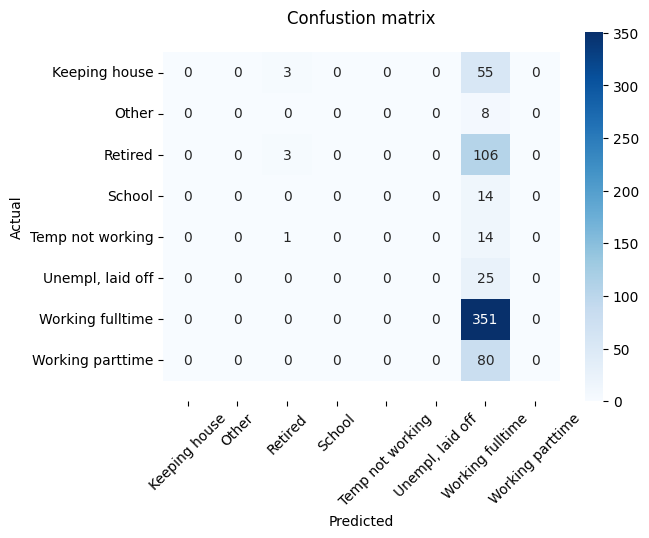

In [35]:
plot_confusion_matrix(y_true, y_pred, target_names)

In [39]:
def train_and_get_performance(X_train, X_test, y_train, y_test, value_to_index=value_to_index, lr=1e-4, num_epochs=10, batch_size=64, num_classes=8):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
    test_dataset = CustomDataset(X_test_tensor, y_test_tensor)
    
    input_size = X_train.shape[1]
    model = MLP(input_size, hidden_size, num_classes)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        model.eval()
        with torch.no_grad():
            y_true = []
            y_pred = []
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                y_true.extend(batch_y.tolist())
                y_pred.extend(predicted.tolist())
                
    # Generate classification report
    target_names = [k for k, v in value_to_index['wrkstat'].items()]
    print(target_names)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    report = classification_report(y_true, y_pred, target_names=target_names)
    
    print("Classification Report:")
    print(report)
    plot_confusion_matrix(y_true, y_pred, target_names)

Epoch [1/10], Loss: 2.0278
Epoch [2/10], Loss: 1.9818
Epoch [3/10], Loss: 1.9742
Epoch [4/10], Loss: 1.9413
Epoch [5/10], Loss: 1.9334
Epoch [6/10], Loss: 1.8899
Epoch [7/10], Loss: 1.8479
Epoch [8/10], Loss: 1.9621
Epoch [9/10], Loss: 1.8534
Epoch [10/10], Loss: 1.8753
['Keeping house', 'Other', 'Retired', 'School', 'Temp not working', 'Unempl, laid off', 'Working fulltime', 'Working parttime']
Classification Report:
                  precision    recall  f1-score   support

   Keeping house       0.00      0.00      0.00        58
           Other       0.00      0.00      0.00         8
         Retired       0.33      0.01      0.02       109
          School       0.00      0.00      0.00        14
Temp not working       0.00      0.00      0.00        15
Unempl, laid off       0.00      0.00      0.00        25
Working fulltime       0.53      1.00      0.69       351
Working parttime       0.00      0.00      0.00        80

        accuracy                           0.53       

c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

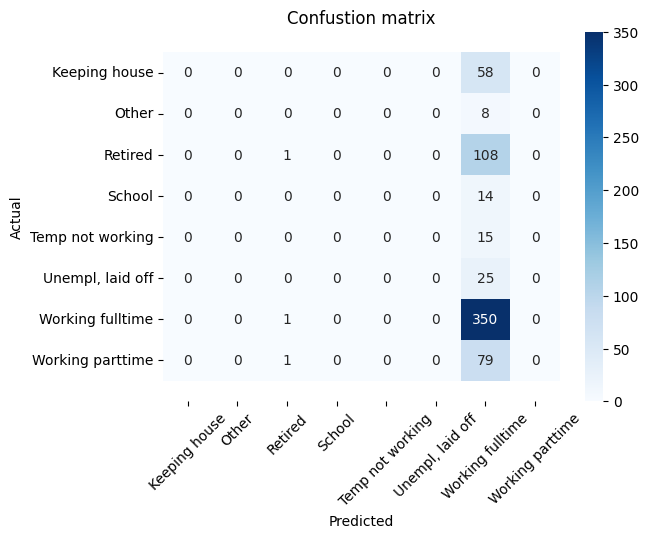

In [48]:
train_and_get_performance(X_train, X_test, y_train, y_test)